## Cookbook: Parallelized *STRUCTURE* analyses on unlinked SNPs

As part of the `ipyrad.analysis` toolkit we've created convenience functions for easily distributing *STRUCTURE* analysis jobs on an HPC cluster, and for doing so in a programmatic and reproducible way. Importantly, *our workflow allows you to easily sample different distributions of unlinked SNPs among replicate analyses*, with the final inferred population structure summarized from a distribution of replicates. We also provide some simple examples of interactive plotting functions to make barplots. 

### A note on Jupyter/IPython
This is a Jupyter notebook, a reproducible and executable document. The code in this notebook is Python (2.7), and should be executed either in a jupyter-notebook, like this one, or in an IPython terminal. Execute each cell in order to reproduce our entire analysis. We make use of the `ipyparallel` Python library to distribute *STRUCTURE* jobs across processers in parallel. If that is confusing, see our [tutorial on using ipcluster with jupyter](). The example data set used in this analysis is from the [empirical example ipyrad tutorial](http://ipyrad.readthedocs.io/pedicularis_.html).

### Required software
You can easily install the required software for this notebook with a locally installed `conda` environment. Just run the commented code below in a terminal. If you are working on an HPC cluster you **do not need** administrator privileges to install the software in this way, since it is only installed locally.

In [38]:
## conda install ipyrad -c ipyrad
## conda install structure -c ipyrad
## conda install clumpp -c ipyrad
## conda install toytree -c eaton-lab

### Import Python libraries

In [2]:
import ipyrad.analysis as ipa      ## ipyrad analysis toolkit
import ipyparallel as ipp          ## parallel processing
import toyplot                     ## plotting library

### Parallel cluster setup
Start an `ipcluster` instance in a separate terminal. An easy way to do this in a jupyter-notebook running on an HPC cluster is to go to your Jupyter dashboard, and click [new], and then [terminal], and run '`ipcluster start`' in that terminal. This will start a local cluster on the compute node you are connected to. See our [ipyparallel tutorial] (coming soon) for further details. 

In [3]:
##
## ipcluster start --n=4
##

In [4]:
## get parallel client
ipyclient = ipp.Client()
print "Connected to {} cores".format(len(ipyclient))

Connected to 4 cores


## Quick guide (tldr;)
The following cell shows the quickest way to results. Further explanation of all of the features and options is provided further below. 

In [5]:
## init an analysis object
s = ipa.structure(
    name="quick",
    workdir="./analysis-structure",
    data="./analysis-ipyrad/pedic-full_outfiles/pedic-full.ustr",
    )

## set main params (use much larger values in a real analysis)
s.mainparams.burnin = 1000
s.mainparams.numreps = 5000

## set N values of K to test across
kvalues = [2, 3, 4, 5, 6]

## submit N replicates of each test to run on parallel client
for kpop in kvalues:
    s.run(kpop=kpop, nreps=4, ipyclient=ipyclient)

## wait for parallel jobs to finish
ipyclient.wait()

submitted 4 structure jobs [quick-K-2]
submitted 4 structure jobs [quick-K-3]
submitted 4 structure jobs [quick-K-4]
submitted 4 structure jobs [quick-K-5]
submitted 4 structure jobs [quick-K-6]


True

In [6]:
## return the evanno table (deltaK) for best K 
s.get_evanno_table(kvalues)

,Nreps,deltaK,estLnProbMean,estLnProbStdev,lnPK,lnPPK
2,4,0.000,-337925.500,374729.242,0.000,0.00
3,4,67.961,-16777.575,4697.207,321147.925,319225.45
4,4,12.556,-14855.100,1505.766,1922.475,18906.25
5,4,9.997,-31838.875,35252.979,-16983.775,352432.15
6,4,0.000,-401254.800,307272.233,-369415.925,0.00


In [24]:
## get admixture proportion tables avg'd across reps
tables = s.get_clumpp_table(kvalues, quiet=True)

## choose a kvalue table for plotting and sort values 
table = tables[3].sort_values(by=[0, 1, 2])

## plot bars w/ hover labels
toyplot.bars(
    table, 
    width=500, 
    height=200,
    title=[[i] for i in table.index.tolist()],
    xshow=False,
);

32082_przewalskii 33588_przewalskii 29154_superba 30686_cyathophylla 41478_cyathophylloides 41954_cyathophylloides 33413_thamno 30556_thamno 35236_rex 35855_rex 40578_rex 39618_rex 38362_rex 32082_przewalskii 33588_przewalskii 29154_superba 30686_cyathophylla 41478_cyathophylloides 41954_cyathophylloides 33413_thamno 30556_thamno 35236_rex 35855_rex 40578_rex 39618_rex 38362_rex 32082_przewalskii 33588_przewalskii 29154_superba 30686_cyathophylla 41478_cyathophylloides 41954_cyathophylloides 33413_thamno 30556_thamno 35236_rex 35855_rex 40578_rex 39618_rex 38362_rex 0.0 0.5 1.0

## Full guide

### Enter input and output file locations
The `.str` file is a structure formatted file output by ipyrad. It includes all SNPs present in the data set. A `.snps.map` file is an optional file that maps which loci each SNP is from. If this file is used then each replicate analysis will *randomly* sample a single SNP from each locus in reach rep. The results from many reps therefore will represent variation across unlinked SNP data sets, as well as variation caused by uncertainty. The `workdir` is the location where you want output files to be written and will be created if it does not already exist. 

In [25]:
## the structure formatted file
strfile = "./analysis-ipyrad/pedic-full_outfiles/pedic-full.str"

## an optional mapfile, to sample unlinked SNPs
mapfile = "./analysis-ipyrad/pedic-full_outfiles/pedic-full.snps.map"

## the directory where outfiles should be written
workdir = "./analysis-structure/"

### Create a *Structure* Class object
Structure is kind of an old fashioned program that requires creating quite a few input files to run, which makes it not very convenient to use in a programmatic and reproducible way. To work around this we've created a convenience wrapper object to make it easy to submit Structure jobs and to summarize their results. 

In [26]:
## create a Structure object
struct = ipa.structure(name="structure-test",
                       data=strfile, 
                       mapfile=mapfile,
                       workdir=workdir)

### Set parameter options for this object
Our Structure object will be used to submit jobs to the cluster. It has associated with it a name, a set of input files, and a large number of parameter settings. You can modify the parameters by setting them like below. You can also use tab-completion to see all of the available options, or print them like below. See the [full structure docs here](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=3&ved=0ahUKEwjt9tjpkszYAhWineAKHZ4-BxAQFgg4MAI&url=https%3A%2F%2Fwww.researchgate.net%2Ffile.PostFileLoader.html%3Fid%3D591c636cdc332d78a46a1948%26assetKey%3DAS%253A495017111953409%25401495032684846&usg=AOvVaw0WjG0uD0MXrs5ResMIHnik) for further details on the function of each parameter. In support of reproducibility, it is good practice to print both the mainparams and extraparams so it is clear which options you used. 

In [27]:
## set mainparams for object
struct.mainparams.burnin = 10000
struct.mainparams.numreps = 100000

## see all mainparams
print struct.mainparams

## see or set extraparams
print struct.extraparams

burnin             10000               
extracols          0                   
label              1                   
locdata            0                   
mapdistances       0                   
markernames        0                   
markovphase        0                   
missing            -9                  
notambiguous       -999                
numreps            100000              
onerowperind       0                   
phased             0                   
phaseinfo          0                   
phenotype          0                   
ploidy             2                   
popdata            0                   
popflag            0                   
recessivealleles   0                   

admburnin           500                 
alpha               1.0                 
alphamax            10.0                
alphapriora         1.0                 
alphapriorb         2.0                 
alphapropsd         0.025               
ancestdist          0            

### Submit jobs to run on the cluster
The function `run()` distributes jobs to run on the cluster and load-balances the parallel workload. It takes a number of arguments. The first, `kpop`, is the number of populations. The second, `nreps`, is the number of replicated runs to perform. Each rep has a different random seed, and if you entered a mapfile for your Structure object then it will subsample unlinked snps independently in each replicate. The `seed` argument can be used to make the replicate analyses reproducible. The `extraparams.seed` parameter will be generated from this for each replicate. And finally, provide it the `ipyclient` object that we created above. The structure object will store an *asynchronous results object* for each job that is submitted so that we can query whether the jobs are finished yet or not. Using a simple for-loop we'll submit 20 replicate jobs to run at four different values of K. 

In [28]:
## a range of K-values to test
tests = [3, 4, 5, 6]

In [9]:
## submit batches of 20 replicate jobs for each value of K 
for kpop in tests:
    struct.run(
        kpop=kpop, 
        nreps=20, 
        seed=12345,
        ipyclient=ipyclient,
        )

submitted 20 structure jobs [structure-test-K-3]
submitted 20 structure jobs [structure-test-K-4]
submitted 20 structure jobs [structure-test-K-5]
submitted 20 structure jobs [structure-test-K-6]


### Track progress until finished
You can check for finished results by using the `get_clumpp_table()` function, which tries to summarize the finished results files. If no results are ready it will simply print a warning message telling you to wait. If you want the notebook to block/wait until all jobs are finished then execute the `wait()` function of the ipyclient object, like below. 

In [11]:
## see submitted jobs (we query first 10 here)
struct.asyncs[:10]

[<AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>]

In [12]:
## query a specific job result by index
if struct.asyncs[0].ready():
    print struct.asyncs[0].result()

In [ ]:
## block/wait until all jobs finished
ipyclient.wait() 

### Summarize replicates with CLUMPP
We ran 20 replicates per K-value hypothesis. We now need to concatenate and purmute those results so they can be summarized. For this we use the software clumpp. The default arguments to clumpp are generally good, but you can modify them the same as structure params, by accessing the `.clumppparams` attribute of your structure object. See the [clumpp documentation](https://web.stanford.edu/group/rosenberglab/software/CLUMPP_Manual.pdf) for more details. If you have a large number of samples (>50) you may wish to use the `largeKgreedy` algorithm (m=3) for faster runtimes. Below we run clumpp for each value of K that we ran structure on. You only need to tell the `get_clumpp_table()` function the value of K and it will find all of the result files given the Structure object's `name` and `workdir`.

In [8]:
## set some clumpp params
struct.clumppparams.m = 3               ## use largegreedy algorithm
struct.clumppparams.greedy_option = 2   ## test nrepeat possible orders
struct.clumppparams.repeats = 10000     ## number of repeats
struct.clumppparams

datatype                  0                   
every_permfile            0                   
greedy_option             2                   
indfile                   0                   
m                         3                   
miscfile                  0                   
order_by_run              1                   
outfile                   0                   
override_warnings         0                   
permfile                  0                   
permutationsfile          0                   
permuted_datafile         0                   
popfile                   0                   
print_every_perm          0                   
print_permuted_data       0                   
print_random_inputorder   0                   
random_inputorderfile     0                   
repeats                   10000               
s                         2                   
w                         1                   

In [31]:
## run clumpp for each value of K
tables = struct.get_clumpp_table(tests)

[K3] 20/20 results permuted across replicates (max_var=0).
[K4] 20/20 results permuted across replicates (max_var=0).
[K5] 20/20 results permuted across replicates (max_var=0).
[K6] 20/20 results permuted across replicates (max_var=0).


In [29]:
## return the evanno table w/ deltaK
struct.get_evanno_table(tests)

,Nreps,deltaK,estLnProbMean,estLnProbStdev,lnPK,lnPPK
3,20,0.000,-146836.325,445572.806,0.000,0.000
4,20,0.218,-151762.425,316342.669,-4926.100,69040.195
5,20,0.288,-225728.720,242763.400,-73966.295,70036.825
6,20,0.000,-369731.840,300321.531,-144003.120,0.000


### Sort the table order how you like it
This can be useful if, for example, you want to order the names to be in the same order as tips on your phylogeny. 

In [32]:
## custom sorting order
myorder = [
    "32082_przewalskii", 
    "33588_przewalskii",
    "41478_cyathophylloides", 
    "41954_cyathophylloides", 
    "29154_superba",
    "30686_cyathophylla", 
    "33413_thamno", 
    "30556_thamno", 
    "35236_rex", 
    "40578_rex", 
    "35855_rex",
    "39618_rex", 
    "38362_rex",
]

print "custom ordering"
print tables[4].ix[myorder]

custom ordering
                          0      1          2      3
32082_przewalskii       1.0  0.000  0.000e+00  0.000
33588_przewalskii       1.0  0.000  0.000e+00  0.000
41478_cyathophylloides  0.0  0.005  9.948e-01  0.000
41954_cyathophylloides  0.0  0.005  9.948e-01  0.000
29154_superba           0.0  0.019  6.731e-01  0.308
30686_cyathophylla      0.0  0.020  6.820e-01  0.298
33413_thamno            0.0  0.845  0.000e+00  0.155
30556_thamno            0.0  0.892  7.000e-04  0.107
35236_rex               0.0  0.908  1.000e-04  0.092
40578_rex               0.0  0.989  2.000e-04  0.010
35855_rex               0.0  0.990  0.000e+00  0.010
39618_rex               0.0  1.000  0.000e+00  0.000
38362_rex               0.0  1.000  0.000e+00  0.000


### A function for adding an interactive hover to our plots
The function automatically parses the table above for you. It can reorder the individuals based on their membership in each group, or based on an input list of ordered names. It returns the table of data as well as a list with information for making interactive hover boxes, which you can see below by hovering over the plots.  

In [33]:
def hover(table):
    hover = []
    for row in range(table.shape[0]):
        stack = []
        for col in range(table.shape[1]):
            label = "Name: {}\nGroup: {}\nProp: {}"\
                .format(table.index[row], 
                        table.columns[col],
                        table.ix[row, col])
            stack.append(label)
        hover.append(stack)
    return list(hover)

### Visualize population structure in barplots 
Hover over the plot to see sample names and info in the hover box. 

In [37]:
for kpop in tests:
    ## parse outfile to a table and re-order it
    table = tables[kpop]
    table = table.ix[myorder]
    
    ## plot barplot w/ hover
    canvas, axes, mark = toyplot.bars(
                            table, 
                            title=hover(table),
                            width=400, 
                            height=200, 
                            xshow=False,                            
                            style={"stroke": toyplot.color.near_black},
                            )

Name: 32082_przewalskii
Group: 0
Prop: 0.0 Name: 33588_przewalskii
Group: 0
Prop: 0.0 Name: 41478_cyathophylloides
Group: 0
Prop: 0.0211 Name: 41954_cyathophylloides
Group: 0
Prop: 0.0211 Name: 29154_superba
Group: 0
Prop: 0.0553 Name: 30686_cyathophylla
Group: 0
Prop: 0.0556 Name: 33413_thamno
Group: 0
Prop: 0.9956 Name: 30556_thamno
Group: 0
Prop: 0.9974 Name: 35236_rex
Group: 0
Prop: 0.9979 Name: 40578_rex
Group: 0
Prop: 0.9986 Name: 35855_rex
Group: 0
Prop: 0.9988 Name: 39618_rex
Group: 0
Prop: 1.0 Name: 38362_rex
Group: 0
Prop: 1.0 Name: 32082_przewalskii
Group: 1
Prop: 0.0 Name: 33588_przewalskii
Group: 1
Prop: 0.0 Name: 41478_cyathophylloides
Group: 1
Prop: 0.9789 Name: 41954_cyathophylloides
Group: 1
Prop: 0.9789 Name: 29154_superba
Group: 1
Prop: 0.9448 Name: 30686_cyathophylla
Group: 1
Prop: 0.9444 Name: 33413_thamno
Group: 1
Prop: 0.0044 Name: 30556_thamno
Group: 1
Prop: 0.0026 Name: 35236_rex
Group: 1
Prop: 0.0021 Name: 40578_rex
Group: 1
Prop: 0.0015 Name: 35855_rex
Group: 1
Prop: 0.0013 Name: 39618_rex
Group: 1
Prop: 0.0 Name: 38362_rex
Group: 1
Prop: 0.0 Name: 32082_przewalskii
Group: 2
Prop: 1.0 Name: 33588_przewalskii
Group: 2
Prop: 1.0 Name: 41478_cyathophylloides
Group: 2
Prop: 0.0 Name: 41954_cyathophylloides
Group: 2
Prop: 0.0 Name: 29154_superba
Group: 2
Prop: 0.0 Name: 30686_cyathophylla
Group: 2
Prop: 0.0 Name: 33413_thamno
Group: 2
Prop: 0.0 Name: 30556_thamno
Group: 2
Prop: 0.0 Name: 35236_rex
Group: 2
Prop: 0.0 Name: 40578_rex
Group: 2
Prop: 0.0 Name: 35855_rex
Group: 2
Prop: 0.0 Name: 39618_rex
Group: 2
Prop: 0.0 Name: 38362_rex
Group: 2
Prop: 0.0 0.0 0.5 1.0

Name: 32082_przewalskii
Group: 0
Prop: 1.0 Name: 33588_przewalskii
Group: 0
Prop: 1.0 Name: 41478_cyathophylloides
Group: 0
Prop: 0.0 Name: 41954_cyathophylloides
Group: 0
Prop: 0.0 Name: 29154_superba
Group: 0
Prop: 0.0 Name: 30686_cyathophylla
Group: 0
Prop: 0.0 Name: 33413_thamno
Group: 0
Prop: 0.0 Name: 30556_thamno
Group: 0
Prop: 0.0 Name: 35236_rex
Group: 0
Prop: 0.0 Name: 40578_rex
Group: 0
Prop: 0.0 Name: 35855_rex
Group: 0
Prop: 0.0 Name: 39618_rex
Group: 0
Prop: 0.0 Name: 38362_rex
Group: 0
Prop: 0.0 Name: 32082_przewalskii
Group: 1
Prop: 0.0 Name: 33588_przewalskii
Group: 1
Prop: 0.0 Name: 41478_cyathophylloides
Group: 1
Prop: 0.0052 Name: 41954_cyathophylloides
Group: 1
Prop: 0.0052 Name: 29154_superba
Group: 1
Prop: 0.0186 Name: 30686_cyathophylla
Group: 1
Prop: 0.0197 Name: 33413_thamno
Group: 1
Prop: 0.8454 Name: 30556_thamno
Group: 1
Prop: 0.8922 Name: 35236_rex
Group: 1
Prop: 0.9081 Name: 40578_rex
Group: 1
Prop: 0.9894 Name: 35855_rex
Group: 1
Prop: 0.9901 Name: 39618_rex
Group: 1
Prop: 1.0 Name: 38362_rex
Group: 1
Prop: 1.0 Name: 32082_przewalskii
Group: 2
Prop: 0.0 Name: 33588_przewalskii
Group: 2
Prop: 0.0 Name: 41478_cyathophylloides
Group: 2
Prop: 0.9948 Name: 41954_cyathophylloides
Group: 2
Prop: 0.9948 Name: 29154_superba
Group: 2
Prop: 0.6731 Name: 30686_cyathophylla
Group: 2
Prop: 0.682 Name: 33413_thamno
Group: 2
Prop: 0.0 Name: 30556_thamno
Group: 2
Prop: 0.0007 Name: 35236_rex
Group: 2
Prop: 0.0001 Name: 40578_rex
Group: 2
Prop: 0.0002 Name: 35855_rex
Group: 2
Prop: 0.0 Name: 39618_rex
Group: 2
Prop: 0.0 Name: 38362_rex
Group: 2
Prop: 0.0 Name: 32082_przewalskii
Group: 3
Prop: 0.0 Name: 33588_przewalskii
Group: 3
Prop: 0.0 Name: 41478_cyathophylloides
Group: 3
Prop: 0.0 Name: 41954_cyathophylloides
Group: 3
Prop: 0.0 Name: 29154_superba
Group: 3
Prop: 0.3084 Name: 30686_cyathophylla
Group: 3
Prop: 0.2983 Name: 33413_thamno
Group: 3
Prop: 0.1546 Name: 30556_thamno
Group: 3
Prop: 0.1071 Name: 35236_rex
Group: 3
Prop: 0.0919 Name: 40578_rex
Group: 3
Prop: 0.0104 Name: 35855_rex
Group: 3
Prop: 0.0099 Name: 39618_rex
Group: 3
Prop: 0.0 Name: 38362_rex
Group: 3
Prop: 0.0 0.0 0.5 1.0

Name: 32082_przewalskii
Group: 0
Prop: 0.0 Name: 33588_przewalskii
Group: 0
Prop: 0.0 Name: 41478_cyathophylloides
Group: 0
Prop: 0.0 Name: 41954_cyathophylloides
Group: 0
Prop: 0.0 Name: 29154_superba
Group: 0
Prop: 0.0263 Name: 30686_cyathophylla
Group: 0
Prop: 0.0346 Name: 33413_thamno
Group: 0
Prop: 0.7078 Name: 30556_thamno
Group: 0
Prop: 0.7924 Name: 35236_rex
Group: 0
Prop: 0.8263 Name: 40578_rex
Group: 0
Prop: 0.9469 Name: 35855_rex
Group: 0
Prop: 0.9486 Name: 39618_rex
Group: 0
Prop: 1.0 Name: 38362_rex
Group: 0
Prop: 1.0 Name: 32082_przewalskii
Group: 1
Prop: 0.0 Name: 33588_przewalskii
Group: 1
Prop: 0.0 Name: 41478_cyathophylloides
Group: 1
Prop: 0.0 Name: 41954_cyathophylloides
Group: 1
Prop: 0.0 Name: 29154_superba
Group: 1
Prop: 0.4769 Name: 30686_cyathophylla
Group: 1
Prop: 0.4415 Name: 33413_thamno
Group: 1
Prop: 0.0075 Name: 30556_thamno
Group: 1
Prop: 0.0153 Name: 35236_rex
Group: 1
Prop: 0.0379 Name: 40578_rex
Group: 1
Prop: 0.0329 Name: 35855_rex
Group: 1
Prop: 0.0305 Name: 39618_rex
Group: 1
Prop: 0.0 Name: 38362_rex
Group: 1
Prop: 0.0 Name: 32082_przewalskii
Group: 2
Prop: 1.0 Name: 33588_przewalskii
Group: 2
Prop: 1.0 Name: 41478_cyathophylloides
Group: 2
Prop: 0.0 Name: 41954_cyathophylloides
Group: 2
Prop: 0.0 Name: 29154_superba
Group: 2
Prop: 0.0 Name: 30686_cyathophylla
Group: 2
Prop: 0.0 Name: 33413_thamno
Group: 2
Prop: 0.0 Name: 30556_thamno
Group: 2
Prop: 0.0 Name: 35236_rex
Group: 2
Prop: 0.0 Name: 40578_rex
Group: 2
Prop: 0.0 Name: 35855_rex
Group: 2
Prop: 0.0 Name: 39618_rex
Group: 2
Prop: 0.0 Name: 38362_rex
Group: 2
Prop: 0.0 Name: 32082_przewalskii
Group: 3
Prop: 0.0 Name: 33588_przewalskii
Group: 3
Prop: 0.0 Name: 41478_cyathophylloides
Group: 3
Prop: 1.0 Name: 41954_cyathophylloides
Group: 3
Prop: 1.0 Name: 29154_superba
Group: 3
Prop: 0.496 Name: 30686_cyathophylla
Group: 3
Prop: 0.5239 Name: 33413_thamno
Group: 3
Prop: 0.0 Name: 30556_thamno
Group: 3
Prop: 0.0 Name: 35236_rex
Group: 3
Prop: 0.0 Name: 40578_rex
Group: 3
Prop: 0.0 Name: 35855_rex
Group: 3
Prop: 0.0 Name: 39618_rex
Group: 3
Prop: 0.0 Name: 38362_rex
Group: 3
Prop: 0.0 Name: 32082_przewalskii
Group: 4
Prop: 0.0 Name: 33588_przewalskii
Group: 4
Prop: 0.0 Name: 41478_cyathophylloides
Group: 4
Prop: 0.0 Name: 41954_cyathophylloides
Group: 4
Prop: 0.0 Name: 29154_superba
Group: 4
Prop: 0.0008 Name: 30686_cyathophylla
Group: 4
Prop: 0.0 Name: 33413_thamno
Group: 4
Prop: 0.2847 Name: 30556_thamno
Group: 4
Prop: 0.1923 Name: 35236_rex
Group: 4
Prop: 0.1358 Name: 40578_rex
Group: 4
Prop: 0.0203 Name: 35855_rex
Group: 4
Prop: 0.0209 Name: 39618_rex
Group: 4
Prop: 0.0 Name: 38362_rex
Group: 4
Prop: 0.0 0.0 0.5 1.0

Name: 32082_przewalskii
Group: 0
Prop: 0.0 Name: 33588_przewalskii
Group: 0
Prop: 0.0 Name: 41478_cyathophylloides
Group: 0
Prop: 0.0 Name: 41954_cyathophylloides
Group: 0
Prop: 0.0 Name: 29154_superba
Group: 0
Prop: 0.4604 Name: 30686_cyathophylla
Group: 0
Prop: 0.4249 Name: 33413_thamno
Group: 0
Prop: 0.0015 Name: 30556_thamno
Group: 0
Prop: 0.0039 Name: 35236_rex
Group: 0
Prop: 0.0289 Name: 40578_rex
Group: 0
Prop: 0.0024 Name: 35855_rex
Group: 0
Prop: 0.003 Name: 39618_rex
Group: 0
Prop: 0.0001 Name: 38362_rex
Group: 0
Prop: 0.0 Name: 32082_przewalskii
Group: 1
Prop: 0.0 Name: 33588_przewalskii
Group: 1
Prop: 0.0 Name: 41478_cyathophylloides
Group: 1
Prop: 0.0 Name: 41954_cyathophylloides
Group: 1
Prop: 0.0 Name: 29154_superba
Group: 1
Prop: 0.0225 Name: 30686_cyathophylla
Group: 1
Prop: 0.0313 Name: 33413_thamno
Group: 1
Prop: 0.647 Name: 30556_thamno
Group: 1
Prop: 0.7293 Name: 35236_rex
Group: 1
Prop: 0.7636 Name: 40578_rex
Group: 1
Prop: 0.81 Name: 35855_rex
Group: 1
Prop: 0.8138 Name: 39618_rex
Group: 1
Prop: 0.9999 Name: 38362_rex
Group: 1
Prop: 1.0 Name: 32082_przewalskii
Group: 2
Prop: 0.0 Name: 33588_przewalskii
Group: 2
Prop: 0.0 Name: 41478_cyathophylloides
Group: 2
Prop: 0.0 Name: 41954_cyathophylloides
Group: 2
Prop: 0.0 Name: 29154_superba
Group: 2
Prop: 0.0 Name: 30686_cyathophylla
Group: 2
Prop: 0.0 Name: 33413_thamno
Group: 2
Prop: 0.3483 Name: 30556_thamno
Group: 2
Prop: 0.1861 Name: 35236_rex
Group: 2
Prop: 0.0632 Name: 40578_rex
Group: 2
Prop: 0.022 Name: 35855_rex
Group: 2
Prop: 0.0224 Name: 39618_rex
Group: 2
Prop: 0.0 Name: 38362_rex
Group: 2
Prop: 0.0 Name: 32082_przewalskii
Group: 3
Prop: 1.0 Name: 33588_przewalskii
Group: 3
Prop: 1.0 Name: 41478_cyathophylloides
Group: 3
Prop: 0.0 Name: 41954_cyathophylloides
Group: 3
Prop: 0.0 Name: 29154_superba
Group: 3
Prop: 0.0 Name: 30686_cyathophylla
Group: 3
Prop: 0.0 Name: 33413_thamno
Group: 3
Prop: 0.0 Name: 30556_thamno
Group: 3
Prop: 0.0 Name: 35236_rex
Group: 3
Prop: 0.0 Name: 40578_rex
Group: 3
Prop: 0.0 Name: 35855_rex
Group: 3
Prop: 0.0 Name: 39618_rex
Group: 3
Prop: 0.0 Name: 38362_rex
Group: 3
Prop: 0.0 Name: 32082_przewalskii
Group: 4
Prop: 0.0 Name: 33588_przewalskii
Group: 4
Prop: 0.0 Name: 41478_cyathophylloides
Group: 4
Prop: 0.0 Name: 41954_cyathophylloides
Group: 4
Prop: 0.0 Name: 29154_superba
Group: 4
Prop: 0.0009 Name: 30686_cyathophylla
Group: 4
Prop: 0.001 Name: 33413_thamno
Group: 4
Prop: 0.0031 Name: 30556_thamno
Group: 4
Prop: 0.0808 Name: 35236_rex
Group: 4
Prop: 0.1443 Name: 40578_rex
Group: 4
Prop: 0.1656 Name: 35855_rex
Group: 4
Prop: 0.1609 Name: 39618_rex
Group: 4
Prop: 0.0 Name: 38362_rex
Group: 4
Prop: 0.0 Name: 32082_przewalskii
Group: 5
Prop: 0.0 Name: 33588_przewalskii
Group: 5
Prop: 0.0 Name: 41478_cyathophylloides
Group: 5
Prop: 1.0 Name: 41954_cyathophylloides
Group: 5
Prop: 1.0 Name: 29154_superba
Group: 5
Prop: 0.5162 Name: 30686_cyathophylla
Group: 5
Prop: 0.5428 Name: 33413_thamno
Group: 5
Prop: 0.0 Name: 30556_thamno
Group: 5
Prop: 0.0 Name: 35236_rex
Group: 5
Prop: 0.0 Name: 40578_rex
Group: 5
Prop: 0.0 Name: 35855_rex
Group: 5
Prop: 0.0 Name: 39618_rex
Group: 5
Prop: 0.0 Name: 38362_rex
Group: 5
Prop: 0.0 0.0 0.5 1.0

### Make a slightly fancier plot and save to file

In [37]:
## save plots for your favorite value of K
table = struct.get_clumpp_table(kpop=3)
table = table.ix[myorder]

mean scores across 20 replicates.


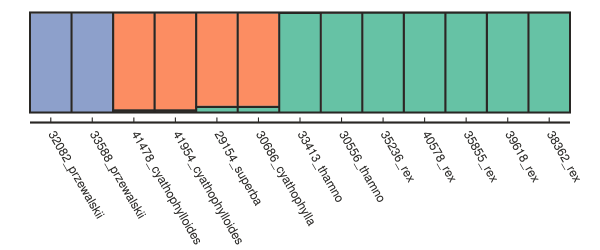

In [38]:
## further styling of plot with css 
style = {"stroke":toyplot.color.near_black, 
         "stroke-width": 2}

## build barplot
canvas = toyplot.Canvas(width=600, height=250)
axes = canvas.cartesian(bounds=("5%", "95%", "5%", "45%"))
axes.bars(table, title=hover(table), style=style)

## add names to x-axis
ticklabels = [i for i in table.index.tolist()]
axes.x.ticks.locator = toyplot.locator.Explicit(labels=ticklabels)
axes.x.ticks.labels.angle = -60
axes.x.ticks.show = True
axes.x.ticks.labels.offset = 10
axes.x.ticks.labels.style = {"font-size": "12px"}
axes.x.spine.style = style
axes.y.show = False
    
## options: uncomment to save plots. Only html retains hover.
import toyplot.svg
import toyplot.pdf
import toyplot.html
toyplot.svg.render(canvas, "struct.svg")
toyplot.pdf.render(canvas, "struct.pdf")
toyplot.html.render(canvas, "struct.html")

## show in notebook
canvas

### Calculating the best K 
...

### Testing for convergence
...

### Copying this notebook to your computer/cluster
You can easily copy this notebook and then just replace my file names with your filenames to run your analysis. Just click on the [Download Notebook] link at the top of this page. Then run `jupyter-notebook` from a terminal and open this notebook from the dashboard.